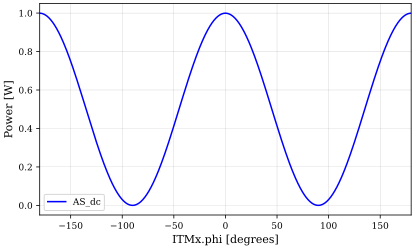

{finesse.detectors.powerdetector.PowerDetector: <Figure size 576x355.968 with 1 Axes>,
 'AS_dc': <Figure size 576x355.968 with 1 Axes>}

In [3]:
#Modelling the MI first!
import finesse
import numpy as np
finesse.configure(plotting=True)
mi=finesse.Model()
mi.parse("""
l laser P=1
s s0 laser.p1 eom.p1 
mod eom midx=0.4 order=1 f=9M

s s1 eom.p2 Bs.p1 L=0
bs Bs R=0.5 T=0.5

#X-arm
s Lx Bs.p3 ITMx.p1 
m ITMx R=1 T=0

#Y-arm
s Ly Bs.p2 ITMy.p1
m ITMy R=1 T=0

pd AS_dc Bs.p4.o 
#pd REFL_dc pr.p1.o
#pd POP_dc pr.p2.o
#pd Arm_trans ITMx.p2.o

xaxis(ITMx.phi,lin,-180,180,1000)

""")
mi.run().plot()

#### The AS will be dark for the C in the MI at ITMx.phi=90
#### PRM is added to the MI, with random lengths.

In [71]:
# prmi=mi.deepcopy()
# prmi.remove("s1")
# prmi.parse("""
# s s1 eom.p2 prm.p1 L=0
# m prm R=0.85 T=0.15
# s pr_Bs prm.p2 Bs.p1 L=3 """)
# prmi.Lx.L=5
# prmi.Ly.L=5
# prmi.ITMx.phi=90 
### This showed an exception, the m and pr_bs definitions are added to the end of the katscript, it is not
### recognised. I'll see what i can do, for now I will create another model, migrating from MI to PRMI.

Text(0.5, 0, 'pr.phi')

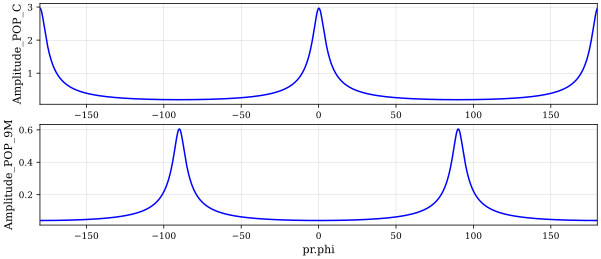

In [5]:
prmi=finesse.Model()
prmi.parse("""
l laser P=1
s s0 laser.p1 eom.p1 L=0
mod eom midx=0.4 order=1 f=9M

#PRM
s s1 eom.p2 prm.p1 L=0
m prm R=0.85 T=0.15           
s pr_Bs prm.p2 Bs.p1 L=4.1665

bs Bs R=0.5 T=0.5 

#X-arm
s Lx Bs.p3 ITMx.p1 L=4.1665
m ITMx R=0.9 T=0.1 phi=90

#Y-arm
s Ly Bs.p2 ITMy.p1 L=4.1665
m ITMy R=0.9 T=0.1

pd AS_dc Bs.p4.o 
pd REFL_dc prm.p1.o
pd POP_dc prm.p2.o

ad POP_C prm.p2.o f=0
ad POP_9M prm.p2.o f=9M
ad AS_C Bs.p4.o f=0
ad AS_9M Bs.p4.o f=9M

xaxis(prm.phi,lin,-180,180,1000)

""")
output=prmi.run()

Amp_POP_C=[]
Amp_POP_9M=[]
phi=np.linspace(-180,180,1000)
for i in range(1000):
    Amp_POP_C.append(abs(output["POP_C"][i]))
    Amp_POP_9M.append(abs(output["POP_9M"][i]))
import matplotlib.pyplot as plt
fig,plots=plt.subplots(2,figsize=(10,4))
plots[0].plot(phi,Amp_POP_C)
plots[0].set_ylabel("Amplitude_POP_C")
plots[1].plot(phi,Amp_POP_9M)
plots[1].set_ylabel("Amplitude_POP_9M")
plots[1].set_xlabel("pr.phi")

#### Optimising the random value by varying the pr-bs length.

In [7]:
llim=1
ulim=10
import numpy as np
phi=np.linspace(0,180,500) #fc+fm sideband.
lengths=np.linspace(llim,ulim,500)
prm_phi_error=[]

for l in np.linspace(llim,ulim,500):
    prmi.pr_Bs.L=l
    output=prmi.run()
    POP_9M=[]
    for i in range(500,1000):
        POP_9M.append(abs(output["POP_9M"][i]))
    prm_phi_error.append(abs(phi[POP_9M.index(max(POP_9M))]-90)) #90 because the anti-resonance of the carrier occurs there.
                                                                 #(peak occurs every 180 deg)      
    #max(Pop_9m is used to locate the peak of SB)
pr_bs_l_opt1=lengths[prm_phi_error.index(min(prm_phi_error))]
print(pr_bs_l_opt1)

4.192384769539078


#### In the above cell, I have varied the the pr-bs length from 2.8 to 3.4. I did that to find the optimum pr-bs length that will see anit-res in C and res in S together.
#### I cannot find the exact value using python, I will have to go back modelling the field equations and see for which pr-bs length, they occur together. So I did a search by changing the length values 500 times! and finding the pr.phi at which SB is resonant. I already knew that the Carrier anti-resonance occurs at pr.phi=90 degrees (irrespective of the pr-bs length). 
#### So I calculated the error (difference between 90 and the pr.phi at which S is res) for all these 500 iterations. Then I found the minimum of this error and set the corresponding length to be the optimum pr-bs length :) 
#### I stopped at 3.4, because my initial guess was 3.35m (with naked eye).

#### I am setting this optimum lenth.

Text(0.5, 0, 'pr.phi')

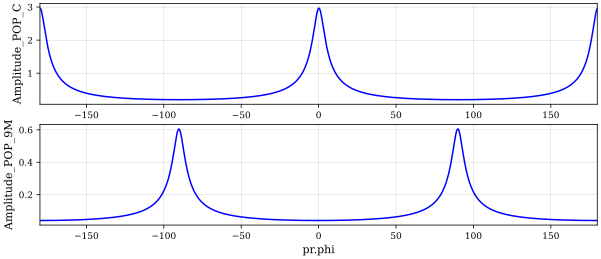

In [8]:
prmi.pr_Bs.L=pr_bs_l_opt1
output=prmi.run()
Amp_POP_C=[]
Amp_POP_9M=[]
phi=np.linspace(-180,180,1000)
for i in range(1000):
    Amp_POP_C.append(abs(output["POP_C"][i]))
    Amp_POP_9M.append(abs(output["POP_9M"][i]))
import matplotlib.pyplot as plt
fig,plots=plt.subplots(2,figsize=(10,4))
plots[0].plot(phi,Amp_POP_C)
plots[0].set_ylabel("Amplitude_POP_C")
plots[1].plot(phi,Amp_POP_9M)
plots[1].set_ylabel("Amplitude_POP_9M")
plots[1].set_xlabel("pr.phi")

#### Now, the res of Sb and anti-res of C occur simultaneously.
#### To bring the necessary resonances to zero phase of xaxis, we will need to set the tuning phase.
#### For which, we will need to know the pr.phi at which the sideband attains a resonance, ideally it must be the angle I must give to bring the anti-resonance of carrier, which is 90 deg. But since the PRC length parameters are chosen randomly, these two do not match!
#### I am finding the pr.phi at which sideband attains resonance and tuning the PRM by that amount.
#### I am setting this angle and not 90 degrees because, I believe the Carrier need not be in a proper anti-resonance, It can be in a very close vicinity of it.

In [9]:
Amplitude=[]
pr_phi=np.linspace(0,180,500) #locating the fc+fm sideband.
for i in range(500,1000,1):
    Amplitude.append(abs(output["POP_9M"][i]))
max_amp=max(Amplitude)
pr_phi_opt1=pr_phi[Amplitude.index(max_amp)]
print("pr_phi_opt:",pr_phi_opt1) #It is slightly less than 90 degrees.

pr_phi_opt: 89.81963927855712


#### I am setting this optimum pr.phi.

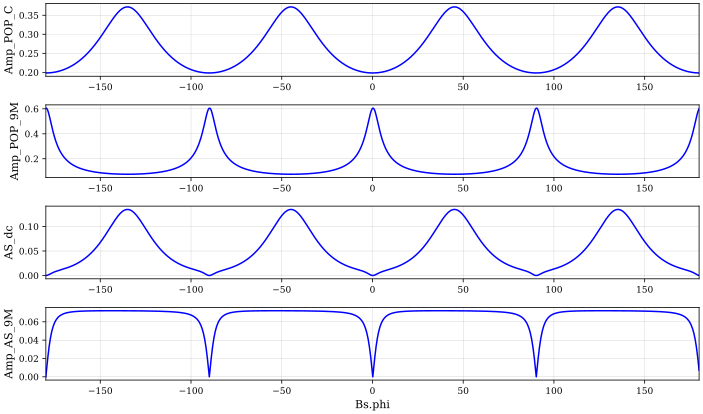

In [11]:
prmi.prm.phi=pr_phi_opt1
prmi.parse("xaxis(Bs.phi,lin,-180,180,1000)")
output=prmi.run()
Amp_POP_C=[]
Amp_POP_9M=[]
Amp_AS_9M=[]
AS_dc=[]
phi=np.linspace(-180,180,1000)
for i in range(1000):
    Amp_POP_C.append(abs(output["POP_C"][i]))
    Amp_POP_9M.append(abs(output["POP_9M"][i]))
    Amp_AS_9M.append(abs(output["AS_9M"][i]))
    AS_dc.append(output["AS_dc"][i])
import matplotlib.pyplot as plt
fig,plots=plt.subplots(4,figsize=(10,6))
plots[0].plot(phi,Amp_POP_C)
plots[0].set_ylabel("Amp_POP_C")
plots[1].plot(phi,Amp_POP_9M)
plots[1].set_ylabel("Amp_POP_9M")
plots[2].plot(phi,AS_dc)
plots[2].set_ylabel("AS_dc")
plots[3].plot(phi,Amp_AS_9M)
plots[3].set_ylabel("Amp_AS_9M")
plots[3].set_xlabel("Bs.phi")
max_amp=max(Amp_AS_9M)
fig.tight_layout()

#### Res of SB and anti-res of C occur together at zero phase of the BS.
#### The DC readout at the AS port is zero, since it is dark for both C and SBs. We will need to set a Schnupp asymmetry to allow SB to AS port.
#### I will find the optimum Schnupp asymmetry that allows maximum SB transmission to the AS port. 

In [63]:
#del_f/f = del_l/l
prcl=pr_bs_l_opt1+4.1665 #(michx+michy)/2
print(prcl)
f=3E8/1064E-9  
del_l=prcl*18E6/f #Schnupp asymmetry
print(del_l)

8.358884769539078
5.336312036873748e-07


In [59]:
prmi.parse("xaxis(Bs.phi,lin,-180,180,1000)") 
output=prmi.run()

0.07207810923002364


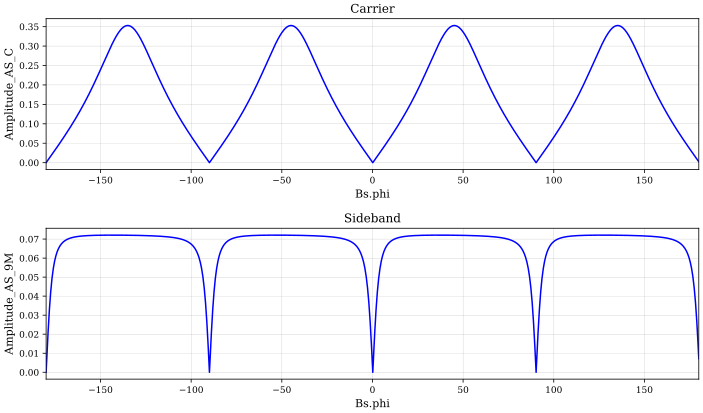

In [60]:
Amp_AS_C=[]
Amp_AS_9M=[]
phi=np.linspace(-180,180,1000)
for i in range(1000):
    Amp_AS_C.append(abs(output["AS_C"][i]))
    Amp_AS_9M.append(abs(output["AS_9M"][i]))
import matplotlib.pyplot as plt
fig,plots=plt.subplots(2,figsize=(10,6))
plots[0].plot(phi,Amp_AS_C)
plots[0].set_ylabel("Amplitude_AS_C")
plots[0].set_xlabel("Bs.phi")
plots[0].set_title("Carrier")
plots[1].plot(phi,Amp_AS_9M)
plots[1].set_ylabel("Amplitude_AS_9M")
plots[1].set_title("Sideband")
plots[1].set_xlabel("Bs.phi")
fig.tight_layout()

max_amp_sb_AS=max(Amp_AS_9M)
print(max_amp_sb_AS)

4.166500533631204


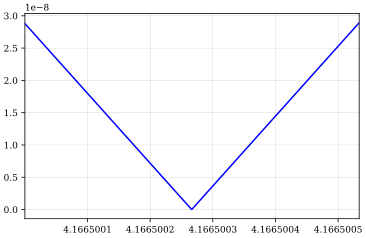

In [62]:
Lx=np.linspace(4.1665,4.1665+del_l,1000)
prmi.parse(f"xaxis(Lx.L,lin,4.1665,4.1665+{del_l},1000)")
output=prmi.run()
amp_AS_9M=[]
for i in range(1000):
    amp_AS_9M.append(abs(output["AS_9M"][i]))
plt.plot(Lx,amp_AS_9M)
print(Lx[amp_AS_9M.index(max(amp_AS_9M))])